### The previous notebook was starting to get muddled, so I am creating a new one with the correct order:
     * dynamically winsorize data w moving average
     * optimize model hyperparameters 
     * compare to previous results

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit

In [3]:
st = st.Stocks()

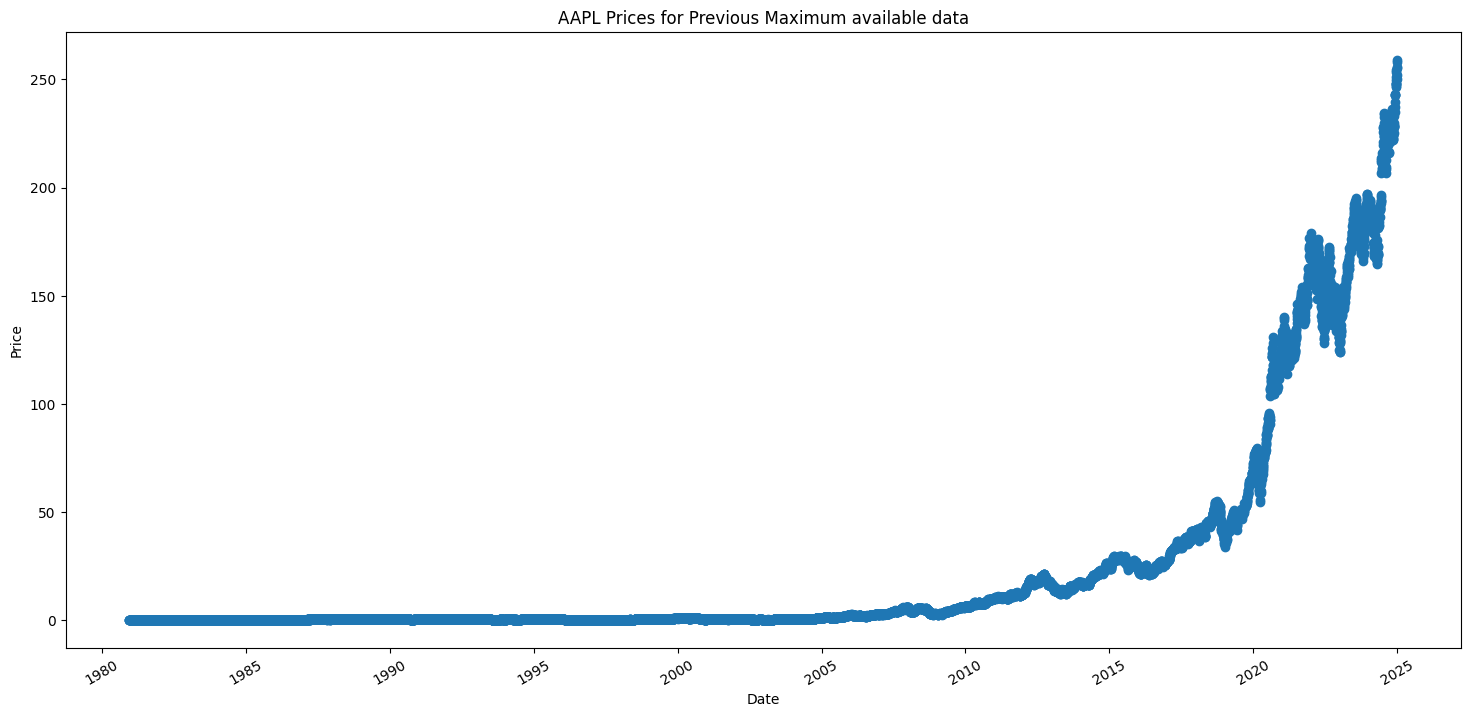

Closing price as of 2024-12-31: $250.42
The percentage change over previous Maximum available data is 253273%
Dividends total $8.77
Stock Splits total $17.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('aapl')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,0.0,0.0
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,0.0,0.0
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,0.0,0.0
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,0.0,0.0
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
34,1981-02-02,0.091959,0.091959,0.091530,0.091530,23766400,0.0,0.0,0.097116,0.121459,0.097116
35,1981-02-03,0.094967,0.095397,0.094967,0.094967,19152000,0.0,0.0,0.095934,0.121459,0.095934
39,1981-02-09,0.094538,0.094538,0.093678,0.093678,16755200,0.0,0.0,0.094258,0.119783,0.094258
41,1981-02-11,0.091100,0.091100,0.090670,0.090670,13843200,0.0,0.0,0.092497,0.116733,0.092497
42,1981-02-12,0.090241,0.090241,0.089810,0.089810,14560000,0.0,0.0,0.091057,0.114670,0.091057


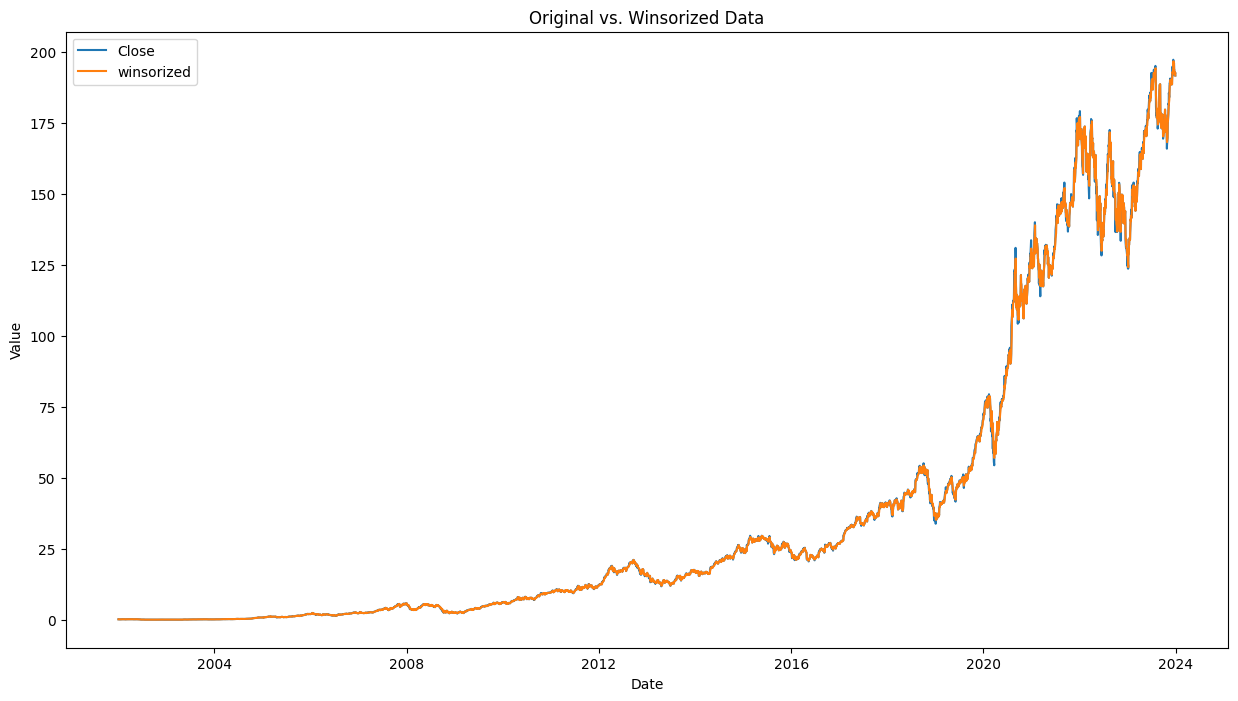

In [9]:
# zoomed view

import matplotlib.pyplot as plt
from datetime import date

# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2023, month=12, day=31)

# Filter the DataFrame based on the date range
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='Date', y=['Close', 'winsorized'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Winsorized Data')
plt.legend()

# Show the plot
plt.show()

### -- create a new baseline model --


In [10]:
# format new dataset for model with 'ds' and 'y'

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
%%time

period=365

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

16:45:17 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 967 ms, sys: 188 ms, total: 1.16 s
Wall time: 3.85 s


In [13]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,23.327148,0.127293,786.478372,28.044222


In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
11465,2025-12-27,231.077018,221.674587,243.516269,230.157696,232.233145,0.743661,0.743661,0.743661,-0.005406,-0.005406,-0.005406,0.749066,0.749066,0.749066,0.0,0.0,0.0,231.820679
11466,2025-12-28,231.141089,220.418807,242.653279,230.213993,232.307685,0.672188,0.672188,0.672188,-0.005406,-0.005406,-0.005406,0.677593,0.677593,0.677593,0.0,0.0,0.0,231.813277
11467,2025-12-29,231.205159,221.663427,242.421910,230.271633,232.380468,0.623666,0.623666,0.623666,0.020907,0.020907,0.020907,0.602759,0.602759,0.602759,0.0,0.0,0.0,231.828825
11468,2025-12-30,231.269230,221.173575,242.197675,230.330045,232.450215,0.549578,0.549578,0.549578,0.024217,0.024217,0.024217,0.525361,0.525361,0.525361,0.0,0.0,0.0,231.818808
11469,2025-12-31,231.333300,221.180490,242.852710,230.388618,232.518903,0.456564,0.456564,0.456564,0.010323,0.010323,0.010323,0.446241,0.446241,0.446241,0.0,0.0,0.0,231.789864


### -- for fun, i want to compare yhat with actual Close now --

In [16]:
forecast['actual_close'] = df.Close

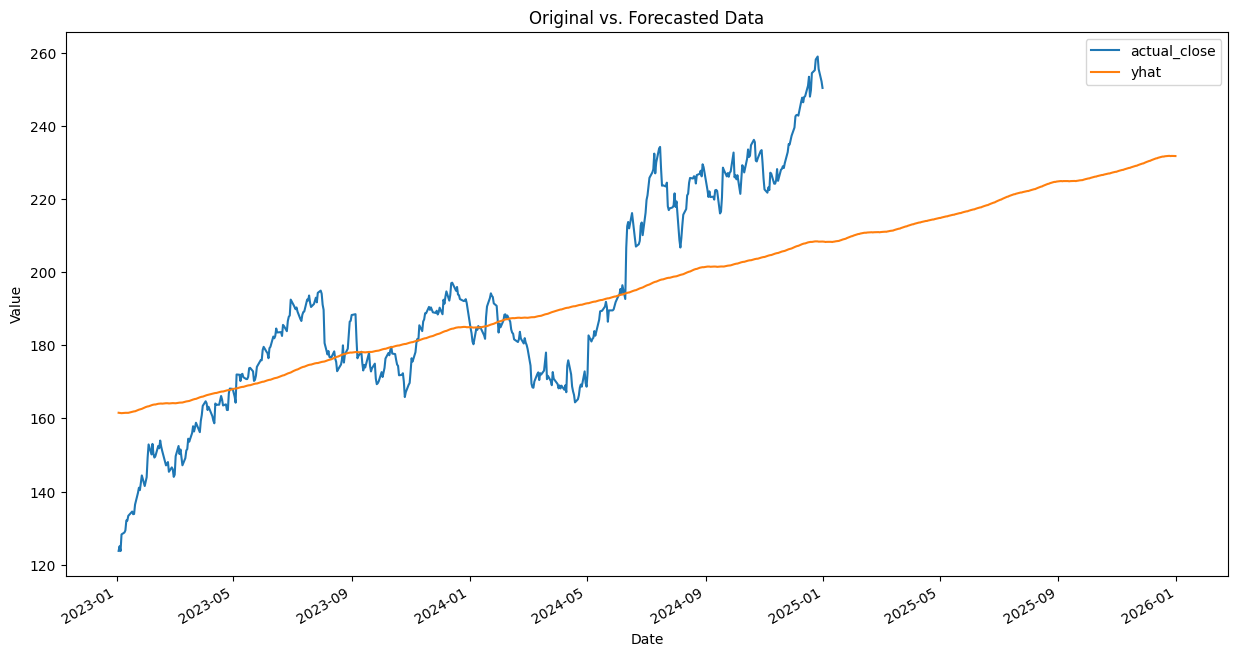

In [17]:
# Define the desired date range
start_date = date(year=2023, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

### aapl observation: mape is 12%. although that sounds great, it does not really capture trends the way i want. it really just looks like a moving average

### -- Cross Validation w Grid Search --

In [18]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
    'seasonality_prior_scale': [0.1, 1, 10] 
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            # Create and fit the model
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale
            )
        m.fit(df_train)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
        df_p = performance_metrics(df_cv)
        score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score
            best_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
                        }

16:45:22 - cmdstanpy - INFO - Chain [1] start processing
16:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/84 [00:00<?, ?it/s]

16:45:24 - cmdstanpy - INFO - Chain [1] start processing
16:45:24 - cmdstanpy - INFO - Chain [1] done processing
16:45:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:45:24 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:25 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/84 [00:00<?, ?it/s]

16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing
16:46:24 - cmdstanpy - INFO - Chain [1] start processing
16:46:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:49 - cmdstanpy - INFO - Chain [1] done processing
16:48:49 - cmdstanpy - INFO - Chain [1] start processing
16:48:50 - cmdstanpy - INFO - Chain [1] done processing
16:48:50 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:52 - cmdstanpy - INFO - Chain [1] done processing
16:48:52 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] done processing
16:48:54 - cmdstanpy - INFO - Chain [1] start processing
16:48:55 - cmdstanpy - INFO - Chain [1] done processing
16:48:55 - cmdstanpy - INFO - Chain [1] start processing
16:48:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:52:37 - cmdstanpy - INFO - Chain [1] start processing
16:52:38 - cmdstanpy - INFO - Chain [1] done processing
16:52:38 - cmdstanpy - INFO - Chain [1] start processing
16:52:38 - cmdstanpy - INFO - Chain [1] done processing
16:52:38 - cmdstanpy - INFO - Chain [1] start processing
16:52:39 - cmdstanpy - INFO - Chain [1] done processing
16:52:39 - cmdstanpy - INFO - Chain [1] start processing
16:52:40 - cmdstanpy - INFO - Chain [1] done processing
16:52:40 - cmdstanpy - INFO - Chain [1] start processing
16:52:40 - cmdstanpy - INFO - Chain [1] done processing
16:52:40 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:42 - cmdstanpy - INFO - Chain [1] done processing
16:52:42 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing
16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:55:32 - cmdstanpy - INFO - Chain [1] start processing
16:55:32 - cmdstanpy - INFO - Chain [1] done processing
16:55:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:55:32 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing
16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:34 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/84 [00:00<?, ?it/s]

16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:18 - cmdstanpy - INFO - Chain [1] done processing
16:56:18 - cmdstanpy - INFO - Chain [1] start processing
16:56:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:17 - cmdstanpy - INFO - Chain [1] done processing
16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:17 - cmdstanpy - INFO - Chain [1] done processing
16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:17 - cmdstanpy - INFO - Chain [1] done processing
16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:17 - cmdstanpy - INFO - Chain [1] done processing
16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:18 - cmdstanpy - INFO - Chain [1] done processing
16:57:18 - cmdstanpy - INFO - Chain [1] start processing
16:57:18 - cmdstanpy - INFO - Chain [1] done processing
16:57:18 - cmdstanpy - INFO - Chain [1] start processing
16:57:18 - cmdstanpy - INFO - Chain [1] done processing
16:57:18 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing
16:57:19 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:13 - cmdstanpy - INFO - Chain [1] done processing
16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:13 - cmdstanpy - INFO - Chain [1] done processing
16:59:13 - cmdstanpy - INFO - Chain [1] start processing
16:59:14 - cmdstanpy - INFO - Chain [1] done processing
16:59:14 - cmdstanpy - INFO - Chain [1] start processing
16:59:14 - cmdstanpy - INFO - Chain [1] done processing
16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:15 - cmdstanpy - INFO - Chain [1] done processing
16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing
16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1]

CPU times: user 2min 17s, sys: 13.2 s, total: 2min 30s
Wall time: 16min 1s


In [19]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

17:01:24 - cmdstanpy - INFO - Chain [1] start processing
17:01:27 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 10}

In [21]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/84 [00:00<?, ?it/s]

17:01:28 - cmdstanpy - INFO - Chain [1] start processing
17:01:28 - cmdstanpy - INFO - Chain [1] done processing
17:01:28 - cmdstanpy - INFO - Chain [1] start processing
17:01:28 - cmdstanpy - INFO - Chain [1] done processing
17:01:28 - cmdstanpy - INFO - Chain [1] start processing
17:01:29 - cmdstanpy - INFO - Chain [1] done processing
17:01:29 - cmdstanpy - INFO - Chain [1] start processing
17:01:29 - cmdstanpy - INFO - Chain [1] done processing
17:01:29 - cmdstanpy - INFO - Chain [1] start processing
17:01:30 - cmdstanpy - INFO - Chain [1] done processing
17:01:30 - cmdstanpy - INFO - Chain [1] start processing
17:01:30 - cmdstanpy - INFO - Chain [1] done processing
17:01:30 - cmdstanpy - INFO - Chain [1] start processing
17:01:31 - cmdstanpy - INFO - Chain [1] done processing
17:01:31 - cmdstanpy - INFO - Chain [1] start processing
17:01:31 - cmdstanpy - INFO - Chain [1] done processing
17:01:32 - cmdstanpy - INFO - Chain [1] start processing
17:01:32 - cmdstanpy - INFO - Chain [1]

CPU times: user 16.8 s, sys: 1.59 s, total: 18.4 s
Wall time: 2min 9s


In [22]:
print(df_p.mean())

horizon     201 days 00:00:00
mse                209.275097
rmse                 14.34726
mae                  5.475792
mape                 0.411481
mdape                0.301003
smape                0.417428
coverage             0.275821
dtype: object


In [23]:
future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

In [24]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,23.782964,0.129818,815.11653,28.550246


In [25]:
forecast['actual_close'] = df.Close

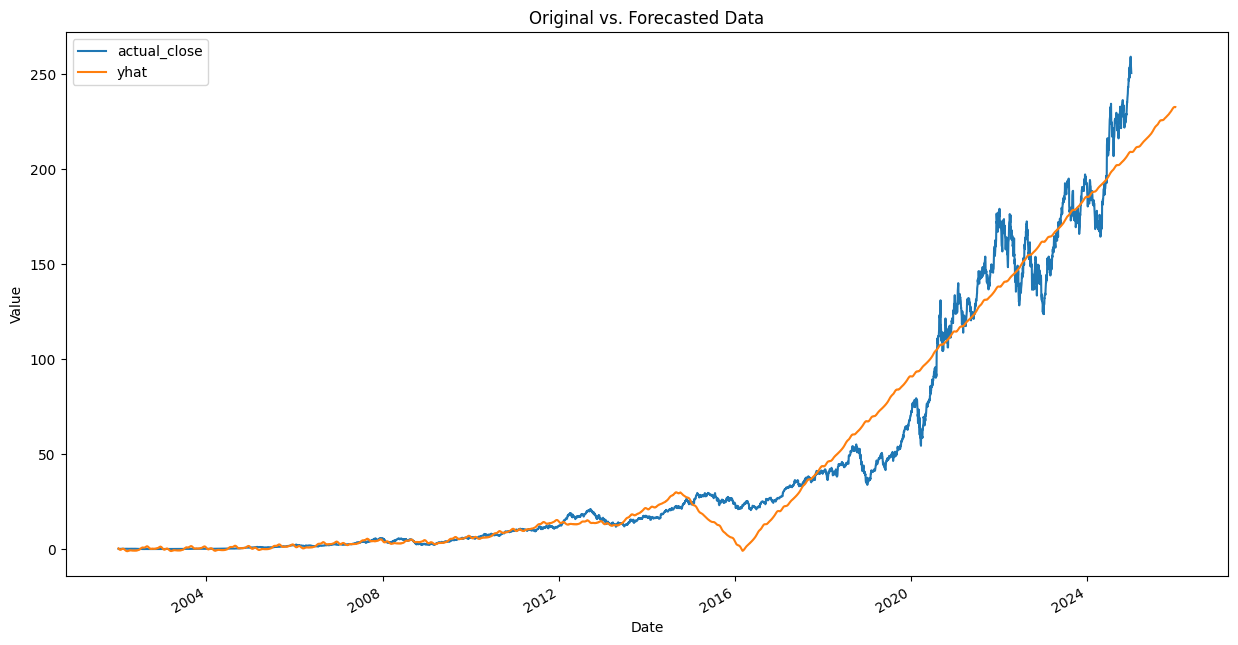

In [26]:
# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [27]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### follow up
* gme mape results are 7.97% better with winsorization than just grid search and cross-validation! (0.310355 vs 0.390088)
    * winsorized model is 25.95% better mape than un-tuned model (0.310355 vs 0.569809)
* figure out what performance_metrics() does to calculate metrics. it is wildly different than get_model_accuracy()
    * get_model_accuracy() measures the error outside of the forecast
    * performance_metrics() measures error from cross-validation
* why is the model just a straight line? like obviously theres a pattern but it doesn't match well with actual price. or is it just GME?
    * i think this got graphed incorrectly.

* evaluate dataset (for volitility?) and put out the best model for that data